# Hypothesis 1
### The number of reviews will fluctuate respective to the economy.
##### When people haven’t the money to spend, they are less likely to go out and therefore less likely to create a review for a business.

We're going to plot the number of reviews per date from a specific location from the Yelp dataset, and it is from this that we'll try to visualize economic change. The number of reviews per date must be normalized by the number of reviewers present to account for the ever-increasing numbers of Yelpers. This is all done below. Following each graphs, some analysis is presented to attempt to account for the data.

(Note, exploratory Python testing is done until marked explicitly later on. Skip down to avoid this.)

In [19]:
import pandas as pd
import numpy as np
import collections
import pickle, os, time
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import pearsonr
from scipy.interpolate import splrep, splev, spline, interp1d, UnivariateSpline
from scipy.optimize import curve_fit

In [2]:
# change this path to your own.
path = "E:/yelp/"

In [3]:
ON_reviews = pd.read_pickle(os.path.join(path, "States", "ON.pkl"))
ON_user_counts = pd.read_pickle(os.path.join(path, "States", "Users", "ON_users.pkl"))

In [4]:
ON_sorted_reviews = ON_reviews.sort_values('date').groupby(['date'], as_index=False).count()
ON_review_counts = ON_sorted_reviews['review_id'].tolist()
ON_review_dates = ON_sorted_reviews['date'].tolist()

ON_user_count_dates = ON_user_counts['yelping_since'].tolist()
ON_user_count_values = ON_user_counts['user_id'].tolist()

In [5]:
def convertUserCountsToSums(user_count_values):
    """
    Converts the counts to a DataFrame of incrementing sums per day.
    
    Args:
        user_count_values (pandas.DataFrame): represents the number of new users per day of a given city/state
    
    Returns:
        [int]: the sum of previous counts at each index
    
    Examples:
        >>> convertUserCountsToSums([1, 4, 6, 2])
        [1, 5, 11, 13]
        
    """
    
    summed_values = []
    summed_values.append(user_count_values[0])
    
    for i in range(1, len(user_count_values)):
        summed_values.append(summed_values[i - 1] + user_count_values[i])
    
    assert len(summed_values) == len(user_count_values)
    return summed_values   

In [6]:
ON_user_count_sums = convertUserCountsToSums(ON_user_count_values)

Now, we have a list of dates and the number of users on Yelp in that state since that date. We next need to normalize the numbers of reviews by the number of viewers present at that date.

In [7]:
def redefineUserCounts(review_dates, user_dates, user_sums):
    """
    Redefines the previously-found user sums to reflect the dates we have review data for.
    
    Args:
        review_dates ([datetime.datetime]): the dates when reviews for a given location have been made
        user_dates ([datetime.datetime]): the dates when users for a given location have made Yelp accounts
        user_sums ([int]): the summed number of total users who have reviewed for a given location
        
    Returns:
        [int]: the summed number of total users who have reviewed for a given location relative to review_dates
    
    """
    
    redefined_counts = []
    
    r = 0
    u = 0
    latest_value = 1  # this prevents a possible divide-by-zero error in the next step
    while r < len(review_dates):
        
        if u >= len(user_dates):
            redefined_counts.append(latest_value)
            r += 1
        
        elif review_dates[r] == user_dates[u]:
            latest_value = user_sums[u]
            redefined_counts.append(latest_value)
            r += 1
            u += 1
            
        elif review_dates[r] > user_dates[u]:
            u += 1
            
        else:  # review_dates[r] < user_dates[u]
            redefined_counts.append(latest_value)
            r += 1
    
    assert len(redefined_counts) == len(review_dates)
    return redefined_counts

In [8]:
ON_new_user_counts = redefineUserCounts(ON_review_dates, ON_user_count_dates, ON_user_count_sums)

We now have a list of user-counts that reflect those found on the dates where we have reviews. Let's normalize the counts by these values and graph them.

In [9]:
ON_normalized_review_counts = [r / u for r,u in zip(ON_review_counts, ON_new_user_counts)]

In [59]:
def plot_city_stats(times, other_axis, redo_x=False, redo_y=False):
    """
    This allows you to plot our dates and normalized counts with a particular x and y axis.
    
    Args:
        times ([datetime.datetime]): the datetimes where reviews are present for a given location
        other_axis ([float]): the review_counts for the datetimes normalized by number of new users on that date
        redo_x ([datetime], optional): two datetimes representing the start and end dates to view on the graph; defaults to False.
        redo_y ([float], optional): two floats representing the upper and lower bounds of the normalized reviews to be viewed on the graph; defaults to False.
    
    """
    
    plottable_dates = date2num([datetime.strptime(i, '%Y-%m-%d') for i in times])
    
    #new_x = np.linspace(min(plottable_dates), max(plottable_dates), 36)
    #new_y = interp1d(plottable_dates, other_axis)(new_x)
    
    #s = UnivariateSpline(plottable_dates, other_axis, s=0)
    #xs = np.linspace(min(plottable_dates), max(plottable_dates), 300)
    #ys = s(xs)
    
    #new_x = np.linspace(min(xs), max(xs), 20)
    #new_y = interp1d(xs, ys)(new_x)
    
    plt.figure(figsize=(20,10))
    plt.plot_date(plottable_dates, other_axis)
    #plt.plot(xs, ys, color='red')
    #plt.plot(new_x, new_y, color='red')
    
    if redo_x:
        plt.xlim(redo_x[0], redo_x[1])
    
    if redo_y:
        plt.ylim(redo_y[0], redo_y[1])
    
    plt.show()
    
    #return new_x, new_y

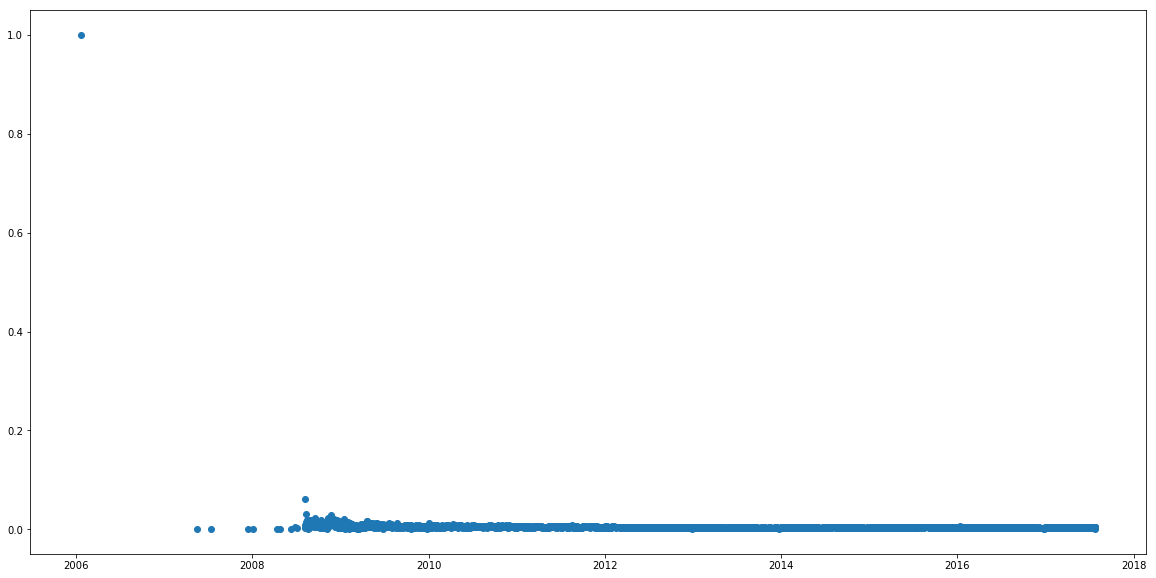

In [60]:
plot_city_stats(ON_review_dates, ON_normalized_review_counts)

Outliers suck. Let's get rid of them by graphing around them. Also there appears to be very little data for times before 2008. No reason to show that in the graph either.

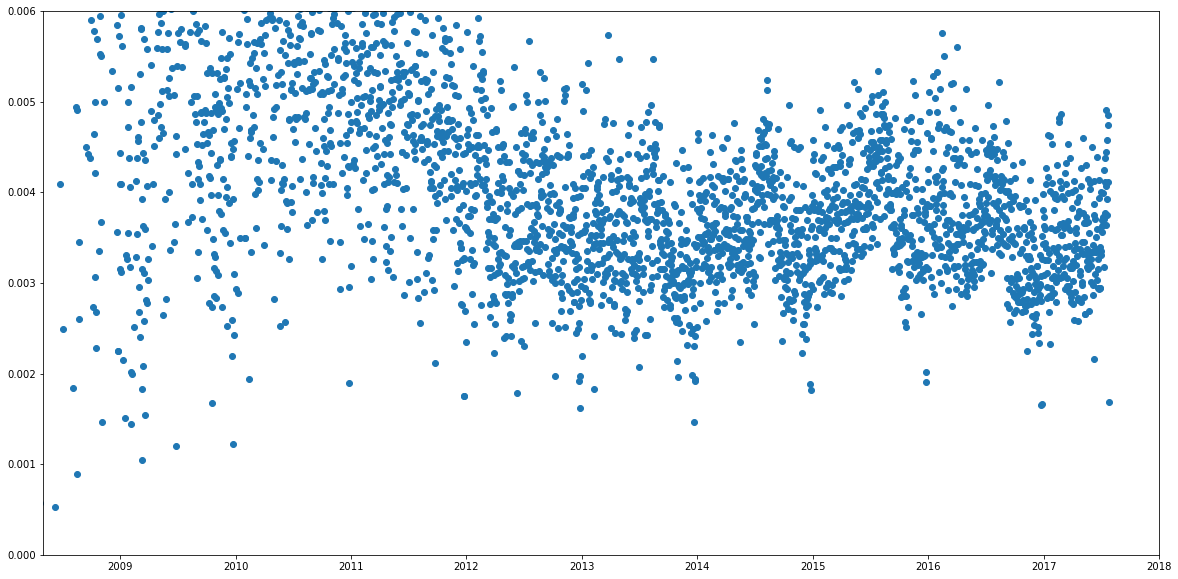

In [61]:
plot_city_stats(ON_review_dates, ON_normalized_review_counts,
                redo_x=[datetime(year=2008, month=5, day=1), datetime(year=2018, month=1, day=1)],
                redo_y=[0.0, 0.006])

Phew... that was a lot of work.... let's make a chunk of code that will allow us to at least create the normalized counts in a much simpler fashion.

In [13]:
def normalizeLocation(state, path, cities_or_states="States"):
    """
    Given a state (or city if you really want to go that route), find the dates of the reviews and the normalized counts per date.
    
    Args:
        state (str): represents the state code or city_state combo
        path (str): the location where all the files for this project can be found
        cities_or_states (str, optional): either "States" or "Cities" and reflects which directory data is being found in
        
    Returns:
        [datetime.datetime]: the dates where reviews for a given location are taken from
        [float]: review counts normalized given new user counts for each date in the datetime
    
    """
    
    reviews = pd.read_pickle(os.path.join(path, cities_or_states, "{}.pkl".format(state)))
    user_counts = pd.read_pickle(os.path.join(path, cities_or_states, "Users", "{}_users.pkl".format(state)))
    
    sorted_reviews = reviews.sort_values('date').groupby(['date'], as_index=False).count()
    review_counts = sorted_reviews['review_id'].tolist()
    review_dates = sorted_reviews['date'].tolist()  # first part to return

    user_count_dates = user_counts['yelping_since'].tolist()
    user_count_values = user_counts['user_id'].tolist()
    
    user_count_sums = convertUserCountsToSums(user_count_values)
    new_user_counts = redefineUserCounts(review_dates, user_count_dates, user_count_sums)
    normalized_review_counts = [r / u for r,u in zip(review_counts, new_user_counts)]  # second part to return
    
    return review_dates, normalized_review_counts

Now we can plot any city or state easily.

(End of exploratory testing.)

In [14]:
NV_reviews, NV_counts = normalizeLocation("NV", path)

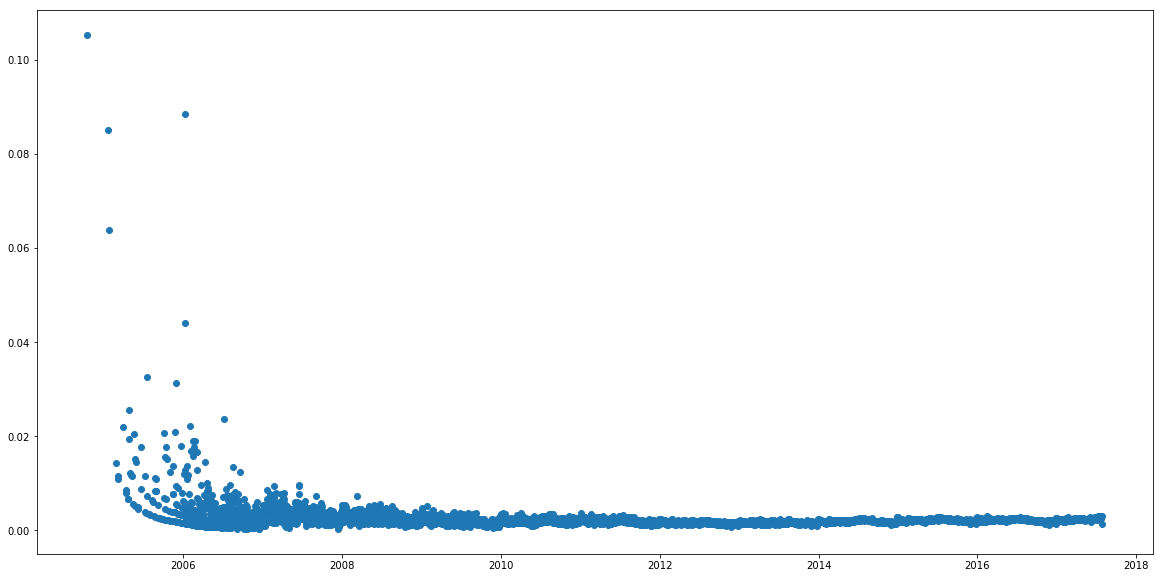

In [62]:
plot_city_stats(NV_reviews, NV_counts)

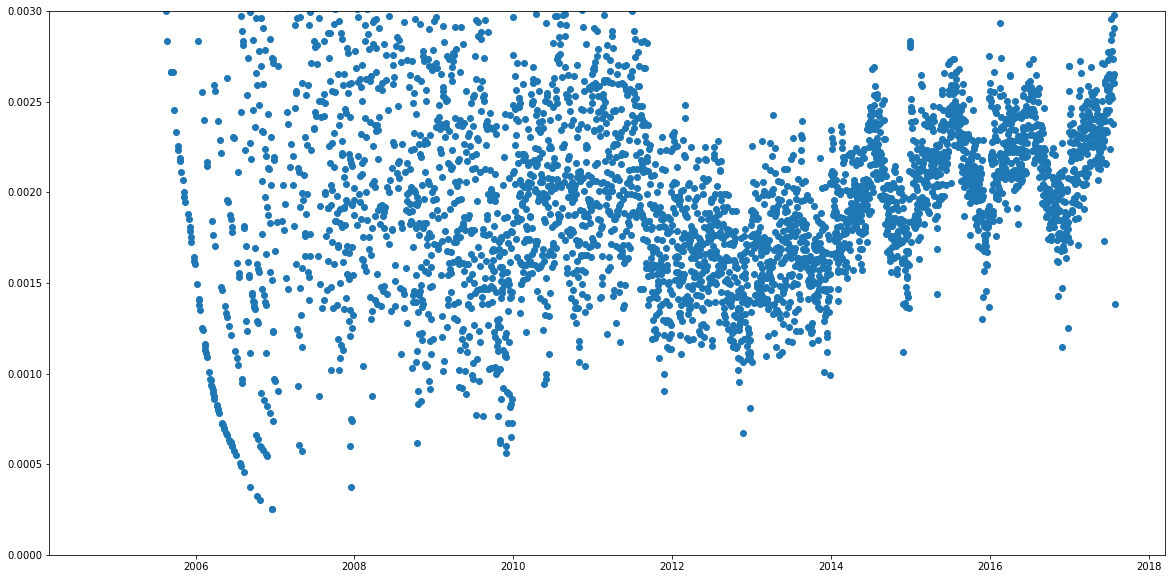

In [63]:
plot_city_stats(NV_reviews, NV_counts,
                redo_y=[0.0, 0.003])

In [17]:
EDH_reviews, EDH_counts = normalizeLocation("EDH", path)

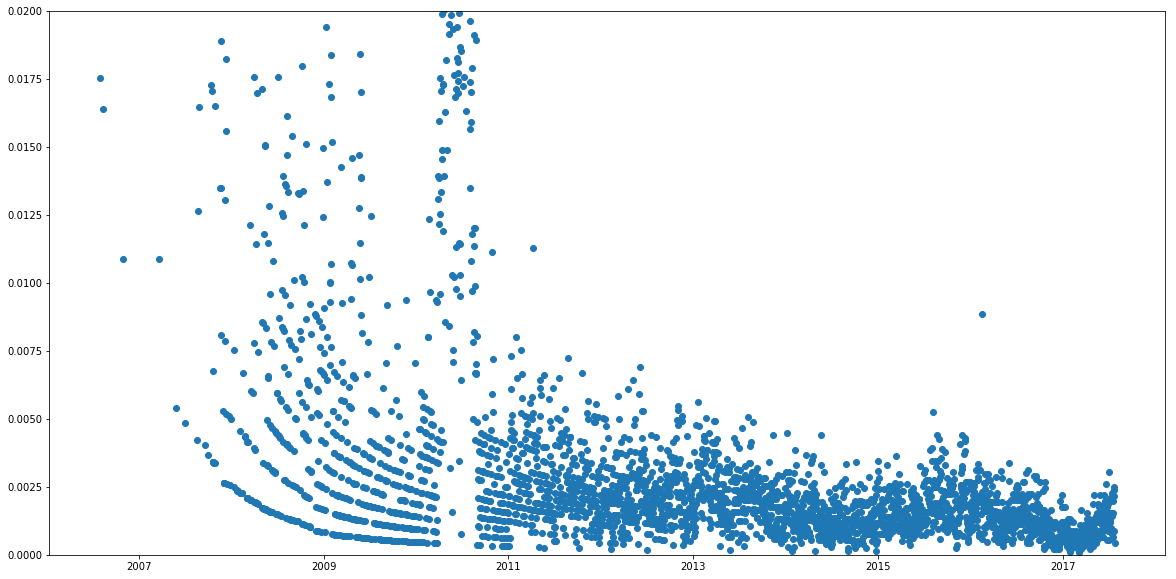

In [64]:
plot_city_stats(EDH_reviews, EDH_counts,
                #redo_x=[datetime(year=2006, month=1, day=1), datetime(year=2018, month=1, day=1)],
                redo_y=[0.0, 0.02]
               )